# Labo 5

In [1]:
%pip install tf_keras_vis tflite-support-nightly

  Using cached tf_keras_vis-0.8.1-py3-none-any.whl (53 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following versions that require a different python version: 0.2.0 Requires-Python >=3.5, <3.8; 0.2.1 Requires-Python >=3.5, <3.8; 0.2.3 Requires-Python >=3.5, <3.8; 0.2.4 Requires-Python >=3.5, <=3.8; 0.2.5 Requires-Python >=3.5, <3.9; 0.3.1 Requires-Python >=3.5, <3.9; 0.3.2 Requires-Python >=3.5, <3.9; 0.3.3 Requires-Python >=3.5, <3.9; 0.4.0 Requires-Python >=3.5, <3.9; 0.5.0 Requires-Python >=3.5, <3.9; 0.5.2 Requires-Python >=3.5, <3.9; 0.5.3 Requires-Python >=3.5, <3.9; 0.5.4 Requires-Python >=3.5, <3.9; 0.5.5 Requires-Python >=3.6, <3.9; 0.6.0 Requires-Python >=3.6, <3.10; 0.6.1 Requires-Python >=3.6, <3.10; 0.6.2 Requires-Python >=3.6, <3.10; 0.7.0 Requires-Python >=3.6, <3.10; 0.7.1 Requires-Python >=3.6, <3.10; 0.7.2 Requires-Python >=3.6, <3.10; 0.8.0 Requires-Python >=3.6, <3.10
ERROR: Could not find a version that satisfies the requirement tflite-support-nightly (from versions: none)
ERROR: No matching distribution found for tflite-support-nightly


## Database creation

In [2]:
import os
import pandas as pd
from glob import glob

def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])

    return pd.DataFrame(data, columns = ["path", "label"])

In [3]:
train_df = create_dataframe_from_directories(os.path.join(".","data"))

In [4]:
LABEL_NAMES = pd.unique(train_df['label'])
LABEL_NAMES

array(['bus', 'cars', 'vans'], dtype=object)

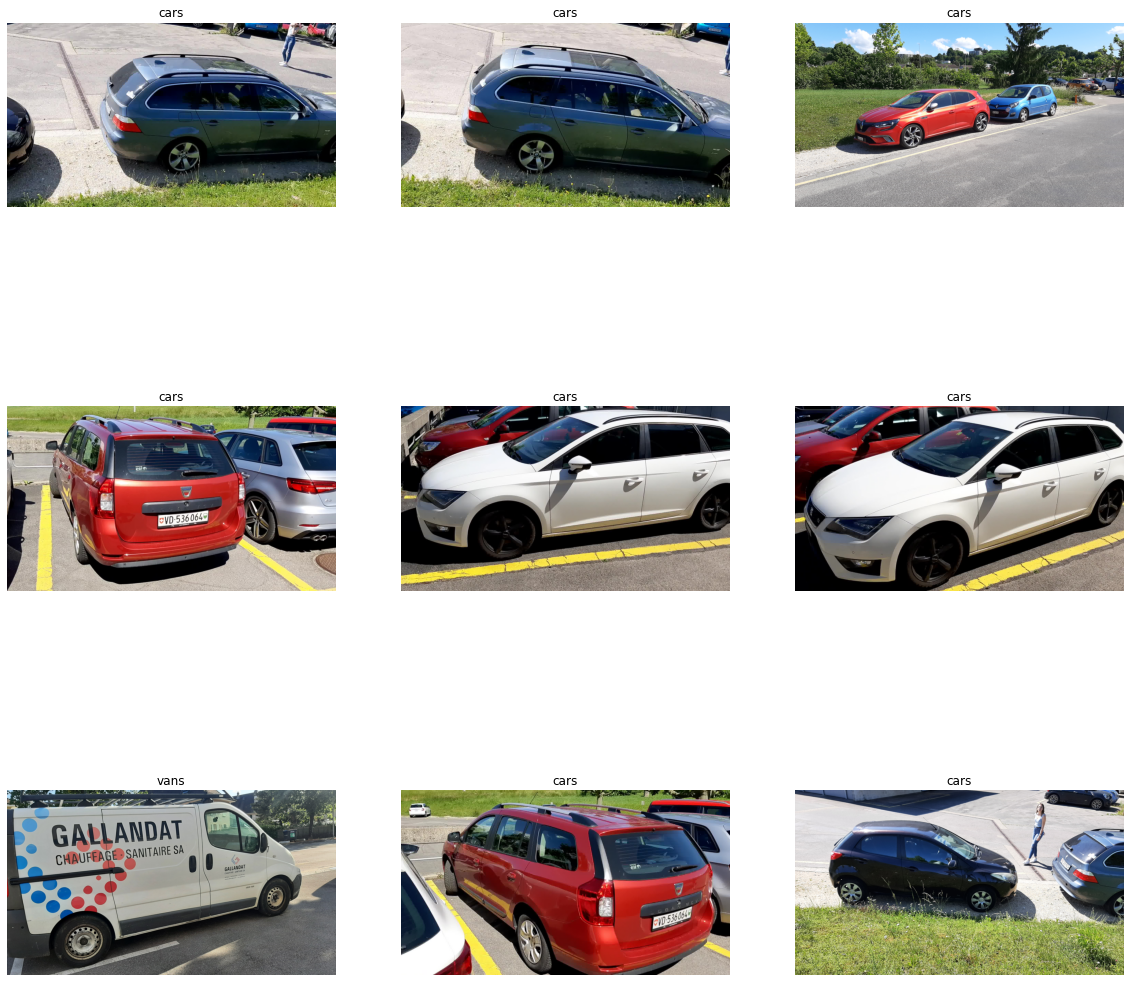

In [12]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image

plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in train_df.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

# Dataset exploration

In [6]:
df_counts = train_df.groupby(["label"])["label"].count()
df_counts

label
bus      13
cars    238
vans     36
Name: label, dtype: int64

label
bus     AxesSubplot(0.125,0.125;0.775x0.755)
cars    AxesSubplot(0.125,0.125;0.775x0.755)
vans    AxesSubplot(0.125,0.125;0.775x0.755)
Name: label, dtype: object

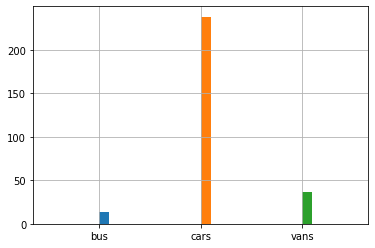

In [7]:
(train_df.groupby(["label"])["label"]).hist()

# Preprocessing steps

In [9]:
from tensorflow.keras.layers import (
    Resizing, Rescaling, RandomFlip, RandomRotation
)

from tensorflow.keras import Sequential

import numpy as np

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation
])

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))

    return opened_img

def augment_image(image):
    return image_augmentations(image)


In [10]:
def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))

    return opened_img

def augment_images(images):
    return np.stack([
        image_augmentations(img) for img in images
    ])

train_df['image'] = train_df.apply(lambda row: augment_image(open_image(row["path"])), axis=1)

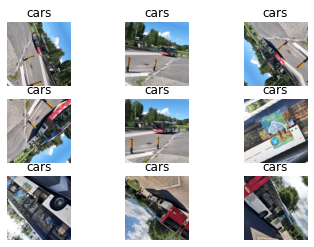

In [11]:
i = 0
for image in train_df.head(9)["image"]:
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

## Define model

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout
)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )

    layers = base_model.output

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on
        GlobalAveragePooling2D(),
        # TODO: ...
    ]

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    # TODO: freeze layers

    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )

    return model

In [15]:
model = get_model()

In [16]:
model.compile()